# 다양한 scaler의 효과
---

## 데이터 준비하기

In [ ]:
from scipy.stats import skewnorm
import numpy as np

x1 = skewnorm.rvs(0, size=(500,1))
x2 = skewnorm.rvs(-100, size=(500,1))
x3 = skewnorm.rvs(100, size=(500,1))
x4 = np.append(
    np.random.normal(3,4,size=(250,1)),
    np.random.normal(-4,1,size=(250,1)), axis=0)

outlier = np.random.uniform(-20,20,size=(10,1))
x1_out = np.append(x1, outlier, axis=0)
x2_out = np.append(x2, outlier, axis=0)
x3_out = np.append(x3, outlier, axis=0)
x4_out = np.append(x4, outlier, axis=0)

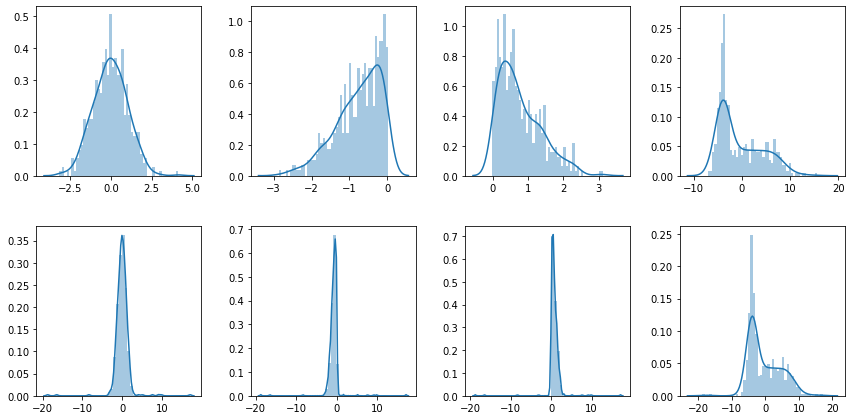

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)
fig.tight_layout()

sns.distplot(x1, bins=50, ax=ax[0, 0])
sns.distplot(x2, bins=50, ax=ax[0, 1])
sns.distplot(x3, bins=50, ax=ax[0, 2])
sns.distplot(x4, bins=50, ax=ax[0, 3])

sns.distplot(x1_out, bins=50, ax=ax[1, 0])
sns.distplot(x2_out, bins=50, ax=ax[1, 1])
sns.distplot(x3_out, bins=50, ax=ax[1, 2])
sns.distplot(x4_out, bins=50, ax=ax[1, 3])

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

# 이상치 없는 정규분포

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer

def show_dist1(x):
  fig, ax = plt.subplots(2,3)
  fig.set_size_inches(9,6)
  fig.tight_layout()

  titles = ['None',
            'MinMax',
            'Standard',
            'Robust',
            'Quantile',
            'Power']
  scalers = [ColumnTransformer([],remainder='passthrough'),
            MinMaxScaler(), 
            StandardScaler(),
            RobustScaler(),
            QuantileTransformer(n_quantiles=50, output_distribution='normal'),
            PowerTransformer()]

  for scaler, title, ax_ in zip(scalers, titles, ax.reshape(-1)):
    res = scaler.fit_transform(x)
    sns.distplot(res, bins=50, ax=ax_)
    ax_.set_title(title)

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

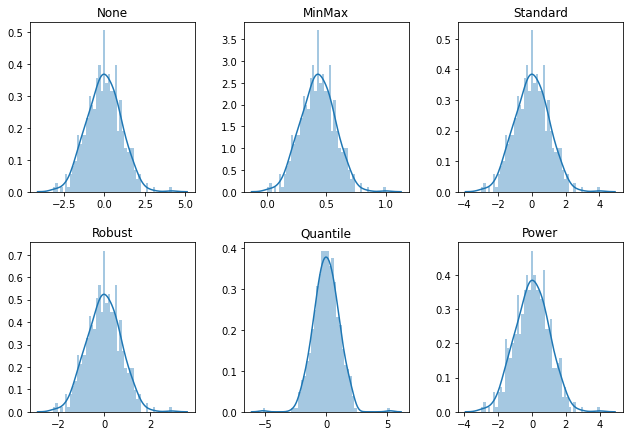

In [ ]:
show_dist1(x1)

전반적으로 다 잘 변환이 되었다.
Quantile을 약간 이상치 비슷하게 양쪽에 생기는게 좀 아쉽다.

# 이상치 없는 왜정규분포

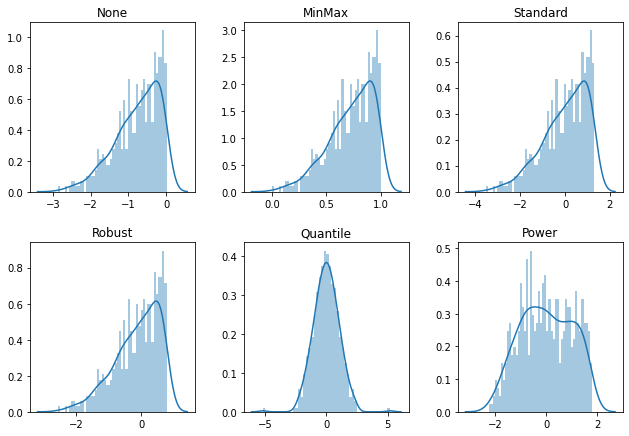

In [ ]:
show_dist1(x2)

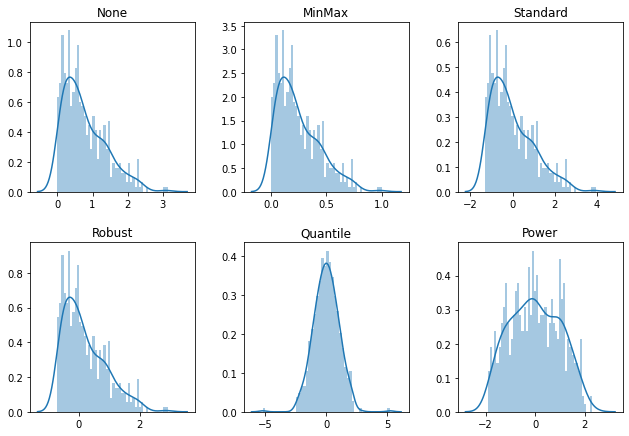

In [ ]:
show_dist1(x3)

Quantile이 약간 깡패인듯하다. 거의 반 강제로 정규분포화 시키는듯하다.
Power도 꽤 괜찮다.
나머지는 왜도를 잡지 못한다.

## 이상치 없는 쌍곡분포

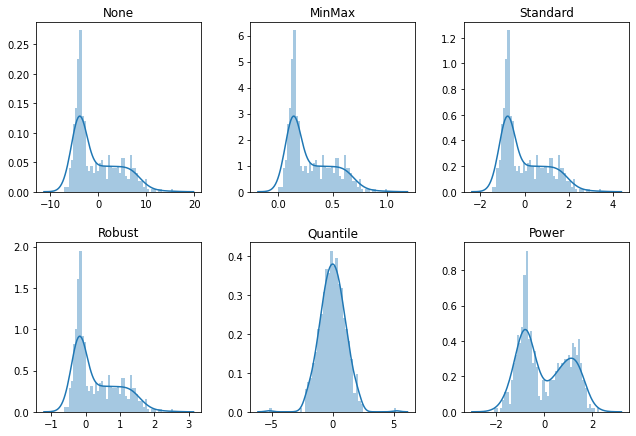

In [ ]:
show_dist1(x4)

쌍곡분포도 그냥 정규분포화 시킨다. 여기까지 오니까 이놈을 써도 되나 약간 무서워진다.

## 이상치 있는 정규분포

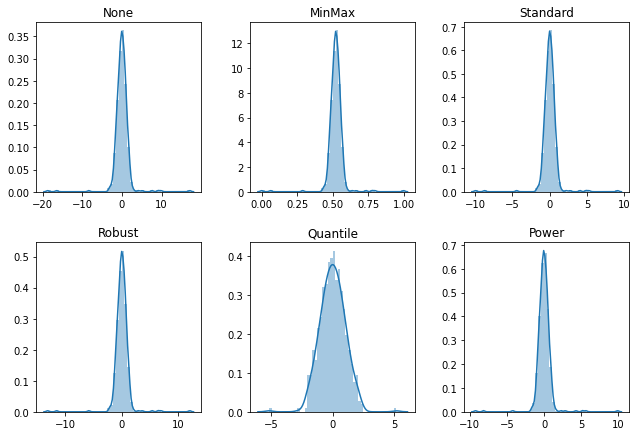

In [ ]:
show_dist1(x1_out)

## 이상치 있는 왜정규분포

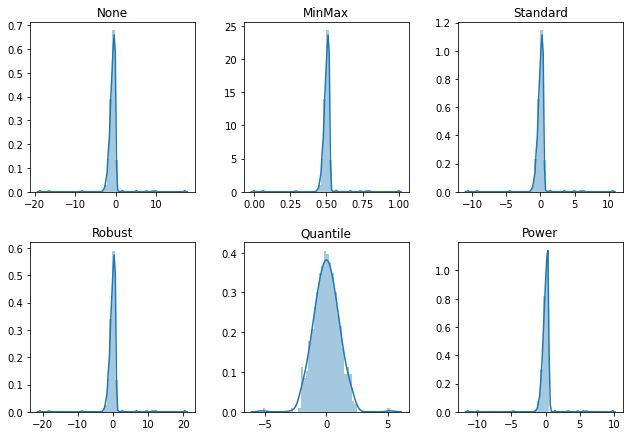

In [ ]:
show_dist1(x2_out)

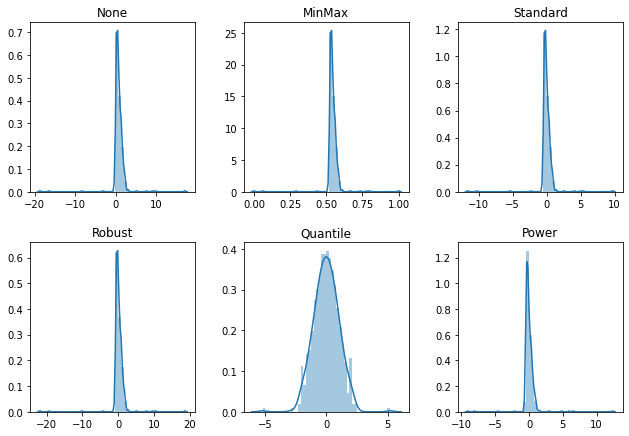

In [ ]:
show_dist1(x3_out)

# 이상치 있는 쌍곡분포

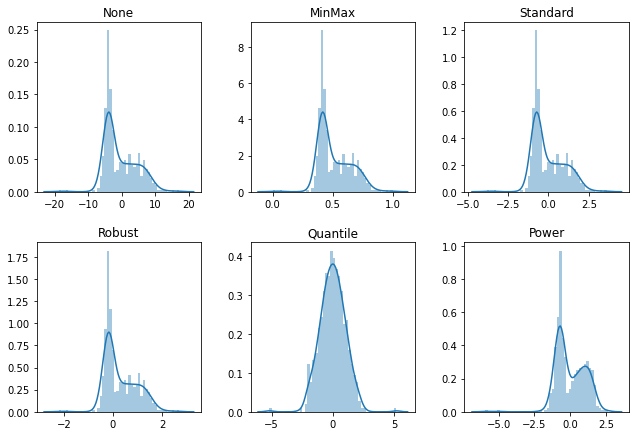

In [ ]:
show_dist1(x4_out)

이상치가 있어도 다른 애들은 정신 못차리는데 quantile은 그냥 다 정규분포화 시키는거같다.

뭐하는 놈인가 싶어서 대충 등간격 배열을 때려넣어 봤다.

In [ ]:
def show_scaler_function(x):
  fig, ax = plt.subplots(2,3)
  fig.set_size_inches(9,6)
  fig.tight_layout()

  titles = ['None',
            'MinMax',
            'Standard',
            'Robust',
            'Quantile',
            'Power']
  scalers = [ColumnTransformer([],remainder='passthrough'),
            MinMaxScaler(), 
            StandardScaler(),
            RobustScaler(),
            QuantileTransformer(n_quantiles=50, output_distribution='normal'),
            PowerTransformer()]

  a = np.linspace(-30,30, 100).reshape(-1,1)

  for scaler, title, ax_ in zip(scalers, titles, ax.reshape(-1)):
    scaler.fit(x)
    res = scaler.transform(a)
    ax_.plot(a, res)
    ax_.set_title(title)
    ax_.set_xlabel('Before')
    ax_.set_ylabel('After')

  plt.subplots_adjust(wspace=0.5, hspace=0.3)
  plt.show()

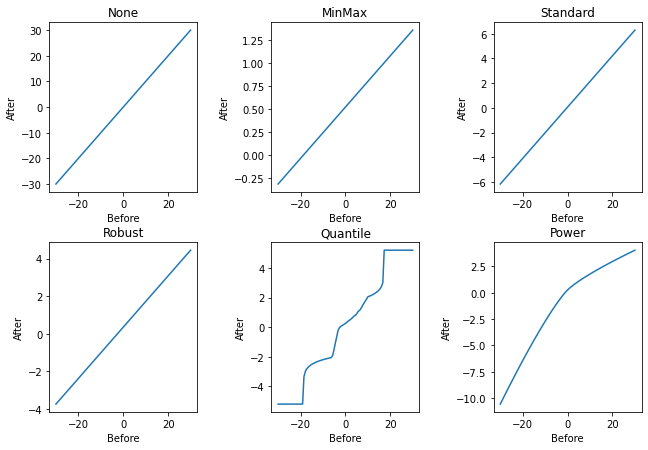

In [ ]:
show_scaler_function(x4_out)

## 잡다한 스킬

### 2단 스케일러

스케일러 하나로는 좀 모자르다 싶으면 이렇게 추가해도 에러는 안 난다.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pipe = Pipeline([('quantile', QuantileTransformer(n_quantiles=50, output_distribution='normal')),
                 ('function', FunctionTransformer(np.arcsinh))
                 ])

### Column마다 다른 스케일러 적용하기

Feature마다 잘 맞는 스케일러가 다를 수 있다. 그럴때는 `ColumnTransformer` 를 쓰면 된다. 이때, `remainder`를 `passthrough`로 놓지 않으면 스케일러를 안 쓴 행들이 반환되지 않는다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

col_trans = ColumnTransformer(
    [('norm1', MinMaxScaler(), [0,1,2,3,4]),
     ('norm2', QuantileTransformer(n_quantiles=50, output_distribution='normal'), [5,6,7,8,9])],
     remainder='passthrough'
     )

model = Pipeline([('스케일러임', col_trans),
                  ('아무나무', RandomForestRegressor())])

어떤 스케일러를 사용할지는 데이터셋에 따라 다 달라서 경험이 쌓이기 전에는 결국 다 해봐야 할 것 같다. 